## Importing libraries

In [19]:
import tensorflow as tf
import json
import optuna
import numpy as np
import pandas as pd
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, Dense, LSTM, Dropout, MaxPooling1D, Bidirectional, SpatialDropout1D, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn  as sns
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report, confusion_matrix

## Loading the data

In [9]:
url_data = 'https://raw.githubusercontent.com/TeodorRusKvi/Tekstanalyse/main/git_NLP_data/'

# Last inn 'X_train_LSTM' fra en CSV-fil
X_df = pd.read_csv(url_data+'X_tensorflow.csv')
# Konverter hele DataFrame til et NumPy array
X = X_df.to_numpy()

# Last inn 'y_train_LSTM' fra en CSV-fil
y_df = pd.read_csv(url_data+'y_liberal.csv')
# Konverter hele DataFrame til et NumPy array
y = y_df.to_numpy()

# Last inn 'y_train_LSTM' fra en CSV-fil
embeddings_GloVe = pd.read_csv(url_data+'embeddings_glove.csv')
# Konverter hele DataFrame til et NumPy array
embeddings_GloVe = embeddings_GloVe.to_numpy()


# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

## Hyperparamatertuning

In [39]:
def model_build(trial, X_train, X_val, y_test, y_val):
    # The hyperparameters we want to tune
    lstm_units = trial.suggest_int("lstm_units", 60, 120, step=1)
    dense_1_units = trial.suggest_int("dense_1_units", 60, 120, step=1)
    dense_2_units = trial.suggest_int("dense_2_units", 60, 120, step=1)
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.2)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-3, 1e-2)

    # Model architecture
    input_layer = Input(shape=(20,))
    embedding = Embedding(input_dim=embeddings_GloVe.shape[0],
                          output_dim=embeddings_GloVe.shape[1],
                          weights=[embeddings_GloVe],
                          trainable=False)(input_layer)
    spatial_dropout = SpatialDropout1D(0.2)(embedding)
    conv1d = Conv1D(filters=64, kernel_size=1, activation='relu')(spatial_dropout)
    dense = Dense(dense_1_units, activation='relu')(conv1d)
    max_pooling = MaxPooling1D()(dense)
    lstm = Bidirectional(LSTM(lstm_units, activation='tanh', recurrent_activation='sigmoid',
                              recurrent_dropout=0.1, return_sequences=True))(max_pooling)
    # global_avg_pool = GlobalAveragePooling1D()(lstm)
    dense = Dense(dense_2_units, activation='relu')(lstm)
    dropout = Dropout(dropout_rate)(dense)
    output_layer = Dense(1, activation='sigmoid')(dropout)

    
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate), metrics=['accuracy'])
    
    return model

def objective(trial):
    model = model_build(trial, X_train, X_val, y_train, y_val)
    
    # Fit the model (adjust epochs and batch_size as needed)
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=64, verbose=0)
    
    # Evaluate the model
    loss, accuracy = model.evaluate(X_val, y_val, verbose=0)
    return -accuracy  # Return negative accuracy to maximize it through minimization

study = optuna.create_study(direction='minimize')  # Direction is minimize because we are minimizing -accuracy
study.optimize(objective, n_trials=100)

[I 2024-04-20 01:15:22,077] A new study created in memory with name: no-name-4613a319-3fb3-42e1-85e3-d24facbfcec5
C:\Users\bugat\AppData\Local\Temp\ipykernel_21456\3935820211.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-3, 1e-2)
[I 2024-04-20 01:16:02,390] Trial 0 finished with value: -0.7620850801467896 and parameters: {'lstm_units': 98, 'dense_1_units': 76, 'dense_2_units': 118, 'dropout_rate': 0.1353877568422595, 'learning_rate': 0.008900827579591925}. Best is trial 0 with value: -0.7620850801467896.
[I 2024-04-20 01:17:42,445] Trial 1 finished with value: -0.753578782081604 and parameters: {'lstm_units': 115, 'dense_1_units': 71, 'dense_2_units': 79, 'dropout_rate': 0.1433580269092666, 'learning_rate': 0.00947183148825862}. Best is trial 0 with value: -0.76

In [40]:
print("Best trial:")
trial = study.best_trial
print(f" Best Validation Accuracy: {-trial.value}")  # Convert back to positive to display
print(" Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

Best trial:
 Best Validation Accuracy: 0.7661307454109192
 Params: 
    lstm_units: 107
    dense_1_units: 65
    dense_2_units: 105
    dropout_rate: 0.18219668546602055
    learning_rate: 0.00335218043181205


In [41]:
#creating a dictionary for the trial data
trial_data = {
    'number': trial.number,
    'params': trial.params,
    'value': trial.value
}

# Saving the trials to json files
with open('best_trial.json', 'w') as f:
    json.dump(trial_data, f)

In [42]:
# Retrieve the best model
# best_params = study.best_trial.params

best_model = model_build(study.best_trial, X_train, X_val, y_train, y_val)

best_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=64, verbose=0)
# Retrain on the full training data

# Evaluate on the test data
loss_1, accuracy_1 = best_model.evaluate(X_test, y_test, verbose=1)
print(f"Test Accuracy: {accuracy_1}")

C:\Users\bugat\AppData\Local\Temp\ipykernel_21456\3935820211.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-3, 1e-2)


61/61 [==============================] - 2s 24ms/step - loss: 0.5074 - accuracy: 0.7617
Test Accuracy: 0.7617417573928833


### Loading the params for the final model

In [6]:
with open('best_trial_1.json', 'r') as f:
    trial = json.load(f)
    params = trial['params']

## The final LSTM-CNN model

In [7]:
def model_build(params, X_train, X_val, y_train, y_val):
    # The extracted parameters from the json file
    lstm_units = params['lstm_units']
    dense_1_units = params['dense_1_units']
    dense_2_units = params['dense_2_units']
    dropout_rate = params['dropout_rate']
    learning_rate = params['learning_rate']

    # Model architecture
    input_layer = Input(shape=(20,))
    embedding = Embedding(input_dim=embeddings_GloVe.shape[0],
                          output_dim=embeddings_GloVe.shape[1],
                          weights=[embeddings_GloVe],
                          trainable=False)(input_layer)
    
    spatial_dropout = SpatialDropout1D(0.2)(embedding)
    conv1d = Conv1D(filters=64, kernel_size=1, activation='relu')(spatial_dropout)
    dense = Dense(dense_1_units, activation='relu')(conv1d)
    max_pooling = MaxPooling1D()(dense)
    lstm = Bidirectional(LSTM(lstm_units, activation='tanh', recurrent_activation='sigmoid',
                              recurrent_dropout=0.1, return_sequences=True))(max_pooling)
    
    lstm = GlobalAveragePooling1D()(lstm)
    dense = Dense(dense_2_units, activation='relu')(lstm)
    dropout = Dropout(dropout_rate)(dense)
    output_layer = Dense(num_classes, activation='sigmoid')(dropout)

    
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate), metrics=['accuracy'])
    
    return model

In [10]:
input_length = 20
num_classes = 1
EPOCHS=20
BATCH_SIZE = 32

model = model_build(params, X_train, X_val, y_train, y_val)

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)


history = model.fit(X_train, y_train,
                    epochs=20,
                    validation_data=(X_val, y_val),
                    batch_size=BATCH_SIZE,
                    callbacks=early_stopping_callback)



Epoch 1/20


282/282 [==============================] - 23s 25ms/step - loss: 0.6037 - accuracy: 0.6806 - val_loss: 0.5627 - val_accuracy: 0.7044
Epoch 2/20
282/282 [==============================] - 5s 19ms/step - loss: 0.5552 - accuracy: 0.7188 - val_loss: 0.5313 - val_accuracy: 0.7417
Epoch 3/20
282/282 [==============================] - 5s 19ms/step - loss: 0.5330 - accuracy: 0.7356 - val_loss: 0.5288 - val_accuracy: 0.7376
Epoch 4/20
282/282 [==============================] - 5s 19ms/step - loss: 0.5149 - accuracy: 0.7482 - val_loss: 0.5272 - val_accuracy: 0.7521
Epoch 5/20
282/282 [==============================] - 5s 19ms/step - loss: 0.5073 - accuracy: 0.7536 - val_loss: 0.5319 - val_accuracy: 0.7516
Epoch 6/20
282/282 [==============================] - 5s 18ms/step - loss: 0.4932 - accuracy: 0.7615 - val_loss: 0.5135 - val_accuracy: 0.7531
Epoch 7/20
282/282 [==============================] - 5s 19ms/step - loss: 0.4763 - accuracy: 0.7680 - val_loss: 0.5117 - val_accuracy: 0

## Evaluation of the model

61/61 [==============================] - 1s 8ms/step - loss: 0.4998 - accuracy: 0.7662
Test Loss: 0.4998432397842407
Test Accuracy: 0.7662001252174377


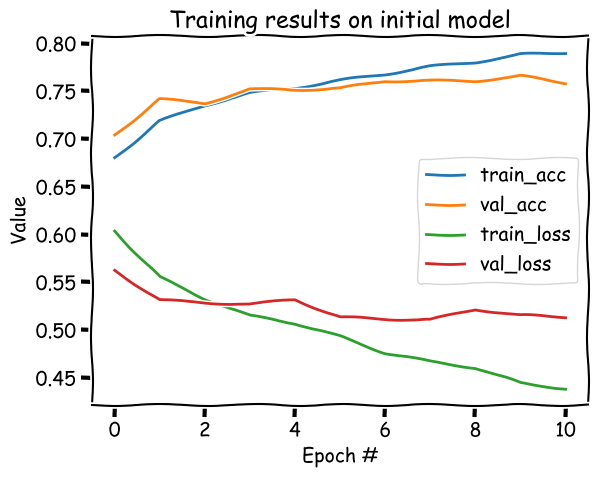

In [13]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

import logging
logging.getLogger('matplotlib.font_manager').disabled = True

with plt.xkcd():
    plt.plot(history.history['accuracy'], label='train_acc')
    plt.plot(history.history['val_accuracy'], label='val_acc')
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')

    plt.xlabel('Epoch #')
    plt.ylabel('Value')
    plt.title('Training results on initial model')
    plt.legend()

    plt.show()

## Classification metrics

31/31 [==============================] - 0s 9ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.53      0.61       665
           1       0.78      0.89      0.83      1264

    accuracy                           0.77      1929
   macro avg       0.75      0.71      0.72      1929
weighted avg       0.76      0.77      0.76      1929

Accuracy: 0.7662001036806636
Recall: 0.8924050632911392
Precision: 0.7817047817047817
F1 Score: 0.833394902105652


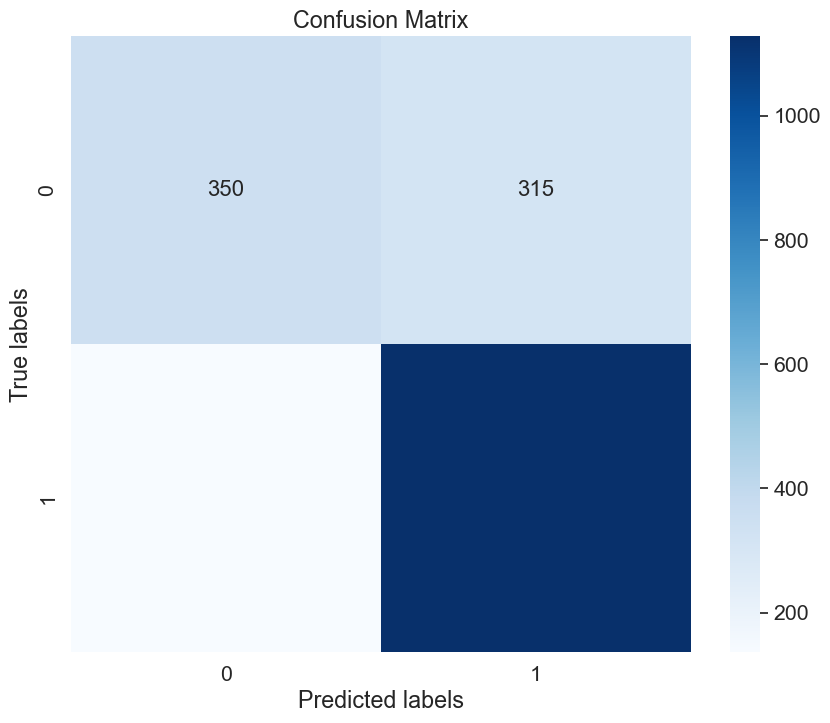

In [21]:
# Predict probabilities for the positive class (class 1)
probabilities = model.predict(X_test, batch_size=64)

# Ensure that probabilities are in the expected format
y_pred = (probabilities > 0.5).astype(int).flatten()

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Calculating different metrics
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Print each metric
print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
print("F1 Score:", f1)

# Creating a confusion matrix for visualization
cm = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(10,8))
sns.set(font_scale=1.4)  # for label size
sns.heatmap(cm, annot=True, annot_kws={"size": 16}, fmt='g', cmap='Blues')  # fmt='g' to avoid scientific notation

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()
